# Purpose:
- Merge ROIs across sessions.
    - Look at the # of sessions each ROI appeared.
        - Per volume.
    - Compare ROI recurrence rate between sessions
        - Vs. sessions passed
        - Vs. estimated mean depth
- See if we have enough # of matched cells to study representational drift.
- Use merging code from 231015_roi_merge_qc.ipynb
    - Also refer to 231021_roi_matching_stats.ipynb

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scripts import roi_collection_across_sessions as rcas
from importlib import reload
from pystackreg import StackReg

base_dir = Path(r'E:\TPM\JK\h5')

expert_mice_df = pd.read_csv(base_dir / 'expert_mice.csv', index_col=0)
use_mice_df = expert_mice_df.loc[expert_mice_df['depth_matched'].astype(bool) & 
                                 ~expert_mice_df['processing_error'].astype(bool) &
                                 ((expert_mice_df.session_type == 'training') |
                                  (expert_mice_df.session_type.str.contains('test')))]



In [32]:
mouse_plane_df = use_mice_df[['mouse', 'plane']].drop_duplicates().reset_index(drop=True)
session_nums_list = []
for i, row in mouse_plane_df.iterrows():
    mouse = row['mouse']
    plane = row['plane']
    session_names = use_mice_df[(use_mice_df.mouse == mouse) & (use_mice_df.plane == plane)].session.values
    session_nums = [int(s) for s in session_names]
    session_nums_list.append(session_nums)



In [33]:
session_nums_list

[[1, 2, 3, 4, 5, 6, 13, 15, 17, 19],
 [1, 2, 3, 4, 5, 6, 13, 15, 17, 19],
 [1, 2, 3, 4, 5, 6, 13, 15, 17, 19],
 [1, 2, 3, 4, 5, 6, 13, 15, 17, 19],
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 7],
 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16],
 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16],
 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16],
 [1, 2, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15, 16],
 [1, 2, 3, 5, 12, 18, 19, 20, 21],
 [1, 2, 3, 5, 12, 18, 19, 20, 21],
 [1, 2, 3, 5, 12, 18, 19, 20, 21],
 [1, 2, 3, 5, 12, 18, 19, 20, 21],
 [1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21],
 [1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 17, 18, 19, 20, 21],
 [1, 2, 3, 5, 6, 7, 9, 11, 12, 14, 15, 1

# Touch hyperplane QC first
- Using MATLAB
- jkWhisker/check_touch_hyperplane.m
- d231210_save_touch_qc_data.m
- 

In [2]:
use_mice_df.keys()

Index(['Unnamed: 0.1', 'mouse', 'plane', 'session', 'session_type',
       'depth_matched', 'processing_error', 'remove_frame_ind'],
      dtype='object')

In [ ]:
mouse_session_df = use_mice_df[['mouse', 'session']].drop_duplicates()


In [11]:
mouse_session_df.query('mouse==52')

,mouse,session
1209,52,003
1211,52,006
1212,52,007
1213,52,008
1214,52,009
1215,52,010
1216,52,011
1217,52,012
1218,52,013
1219,52,014


### JK036 S01
- There were two hyperplanes, due to a sudden change in radial distance at trial 247.
- Trials before 247 were processed as S81. (The rest were processed as S91 first, but then again in S01)
- final.mat file and pkl files were created after copying S81 to S01.

# ROI matching
- Ref 220627_roi_collection_and_QC.ipynb and 220605_roi_collection_and_QC.py
   - ROI collection part only (not signal extraction) 
- Functions collected in roi_collection_across_sessions.py
   - There could be errors (e.g., multi-matching ROIs)

In [ ]:

reload(rcas)
rcas.run_roi_collection(25, 1, base_dir)

In [19]:
mice = expert_mice_df.mouse.unique()
print(mice)

[25 27 30 36 39 52]


In [ ]:
error_planes = []
for mouse in mice:
    for pn in range(1,9):
        try:
            rcas.run_roi_collection(mouse, pn, base_dir)
        except:
            error_planes.append((mouse, pn))

# Running in parallel
- roi_collection_across_sessions.py

# Check parallel run results
- Master map generation
- ROI index match back to each session

In [6]:
mice = expert_mice_df.mouse.unique()
planes = np.arange(1,9)
mm_error_planes = []
roi_error_planes = []
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        master_roi_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_master_roi.npy'
        cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_roi_collection.npy'
        if not master_roi_fn.exists():
            mm_error_planes.append((mouse, pn))
        if not cp_roi_collection_results_fn.exists():
            roi_error_planes.append((mouse, pn))


In [7]:
len(mm_error_planes)

0

In [8]:
len(roi_error_planes)

31

### Error planes
- 28 errors when making the master map
- 3 additional errors when matching the indices back to each session
### Look at each errors and fix the problem

In [9]:
mm_error_planes

[(27, 8),
 (30, 1),
 (30, 2),
 (30, 3),
 (30, 4),
 (30, 5),
 (30, 6),
 (30, 7),
 (30, 8),
 (36, 1),
 (36, 2),
 (36, 3),
 (36, 4),
 (36, 6),
 (39, 1),
 (39, 2),
 (39, 3),
 (39, 4),
 (39, 5),
 (39, 6),
 (39, 7),
 (39, 8),
 (52, 3),
 (52, 4),
 (52, 5),
 (52, 6),
 (52, 7),
 (52, 8)]

In [12]:
mouse, plane = mm_error_planes[0]

roi_overlap_threshold=0.5

plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_collection.npy'
reg_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'


reg_result = np.load(reg_fn, allow_pickle=True).item()
num_sessions = len(reg_result['selected_session_num'])
reg_meth = reg_result['registration_method']
# Fix the error with suite2p method offsets (was collecting in a wrong way)
# Match them with the 'old' method (2022/07/13 JK)
if reg_meth == 'suite2p':
    reg_result = rcas.fix_reg_collection(reg_result)

# Retrieve buffers, options, and dimensions
if reg_meth == 'old':
    reg_result_ops = reg_result['old_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'suite2p':
    reg_result_ops = reg_result['suite2p_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'affine':
    reg_result_ops = reg_result['affine_result']
elif reg_meth == 'bilinear':
    reg_result_ops = reg_result['bilinear_result']
else:
    raise('Registration method mismatch.')
reg_img = reg_result_ops['reg_image']
Ly, Lx = reg_img.shape[1:]

# Session-to-session registration creates non-overlaping regions at the edges.
# Set registration boundary to remove ROIs from each session that overlaps with the boundary.
if reg_meth == 'old' or reg_meth == 'suite2p':
    top_edge = max(reg_result_ops['roff1'][0][0])+5 # Adding 5 for nonrigid and 2nd step registrations.
    bottom_edge = min(reg_result_ops['roff1'][0][0])-5
    left_edge = max(reg_result_ops['roff1'][0][1])+5
    right_edge = min(reg_result_ops['roff1'][0][1])-5
    registration_boundary = np.ones(reg_img.shape[1:], 'uint8')
    registration_boundary[top_edge:bottom_edge, left_edge:right_edge] = 0
else:
    registration_boundary = np.sum(reg_img > 0,axis=0) < reg_img.shape[0]

# Go through sessions and collect ROIs into the master ROI map
# Pre-sessions (901 and 902) should be at the beginning

masterMap = np.zeros(0, 'bool')

srBi = StackReg(StackReg.BILINEAR)
srAffine = StackReg(StackReg.AFFINE)

leftBuffer = reg_result['edge_buffer']['leftBuffer']
topBuffer = reg_result['edge_buffer']['topBuffer']
rightBuffer = reg_result['edge_buffer']['rightBuffer']
bottomBuffer = reg_result['edge_buffer']['bottomBuffer']

master_map_list = []
new_master_map_list = []
session_map_list = []
new_map_list = []
viable_cell_index_list = []

# for test
session_og_map_list = []
session_after_buffer_map_list = []
session_reg_map_list = []
session_cut_map_list = []

print(f'ROI collection: JK{mouse:03} plane {pn}')
for si in range(num_sessions):
    snum = reg_result['selected_session_num'][si]
    sname = f'{mouse:03}_{snum:03}'
    print(f'Processing JK{mouse:03} plane {pn} {sname} {si}/{num_sessions-1}')
    
    if (reg_meth == 'old') or (reg_meth == 'suite2p'):
        rigid_y1 = reg_result_ops['roff1'][0][0][si]
        rigid_x1 = reg_result_ops['roff1'][0][1][si]
        nonrigid_y1 = reg_result_ops['nroff1'][0][0][si]
        nonrigid_x1 = reg_result_ops['nroff1'][0][1][si]
        
        rigid_y2 = reg_result_ops['roff2'][0][0][si]
        rigid_x2 = reg_result_ops['roff2'][0][1][si]
        nonrigid_y2 = reg_result_ops['nroff2'][0][0][si]
        nonrigid_x2 = reg_result_ops['nroff2'][0][1][si]

        block_size1 = reg_result_ops['block_size1']
        block_size2 = reg_result_ops['block_size2']
    
    # Gather cell map and log session cell index for QC
    tempStat = np.load(plane_dir / f'{snum:03}/plane0/roi/stat.npy', allow_pickle=True)
    tempIscell = np.load(plane_dir / f'{snum:03}/plane0/roi/iscell.npy', allow_pickle=True)
    ops = np.load(plane_dir / f'{snum:03}/plane0/roi/ops.npy', allow_pickle=True).item()
    Ly, Lx = ops['Ly'], ops['Lx']

    if 'inmerge' in tempStat[0].keys():
        merged_ind = np.where([ts['inmerge']>0 for ts in tempStat])[0]
        if len(merged_ind) > 0:
            tempIscell[merged_ind,0] = 0
    tempCelli = np.where(tempIscell[:,0])[0]
    numCell = len(tempCelli)
    tempMap = np.zeros((numCell,Ly,Lx), 'bool')
    for n, ci in enumerate(tempCelli):
        xi = tempStat[ci]['xpix']
        yi = tempStat[ci]['ypix']
        tempMap[n,yi,xi] = 1

    # Remove ROIs overlapping with the registration buffer (for bidirectional noise and optotune ringing noise)
    registration_buffer = np.ones(tempMap.shape[1:], 'uint8')
    registration_buffer[topBuffer:-bottomBuffer, leftBuffer:-rightBuffer] = 0
    ind_remove_buffer = np.where(np.sum((tempMap * registration_buffer), axis=(1,2)))[0]
    tempMap = np.delete(tempMap, ind_remove_buffer, axis=0)
    tempCelli = np.delete(tempCelli, ind_remove_buffer)
    tempMap = tempMap[:,topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
    session_og_map_list.append(tempMap)

    # remove ROIs overlappting with the registration boundary.
    # (a little chopped-off ROI could still remain and be transformed.)
    ind_remove_boundary = np.where(np.sum((tempMap * registration_boundary), axis=(1,2)))[0]
    tempMap = np.delete(tempMap, ind_remove_boundary, axis=0)
    tempCelli = np.delete(tempCelli, ind_remove_boundary)
    numCell = len(tempCelli)

    session_after_buffer_map_list.append(tempMap)
    
    # Transform
    if (reg_meth == 'old') or (reg_meth == 'suite2p'):
        tempRegMap = rcas.twostep_register(tempMap, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                        rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
    elif reg_meth == 'affine':
        tempRegMap = np.zeros(tempMap.shape)
        for trmi in range(tempRegMap.shape[0]):
            tempRegMap[trmi,:,:] = srAffine.transform(tempMap[trmi,:,:], tmat=reg_result_ops['tforms'][si])
    elif reg_meth == 'bilinear':
        tempRegMap = np.zeros(tempMap.shape)
        for trmi in range(tempRegMap.shape[0]):
            tempRegMap[trmi,:,:] = srBi.transform(tempMap[trmi,:,:], tmat=reg_result_ops['tforms'][si])
    else:
        raise('Registration method mismatch')
    session_reg_map_list.append(tempRegMap)

    # Transformation makes ROI map float values, not binary. 
    # Select threshold per cell after transformation, to have (roughly) matching # of pixels before the transformation
    # Save this threshold value per cell per session
    cutMap = np.zeros((numCell, *reg_img.shape[1:]), 'bool')
    delFromCut = []
    warpCellThresh = np.zeros(numCell)
    after_transform_boundary = np.ones(tempRegMap.shape[1:])
    after_transform_boundary[1:-1,1:-1] = 0
    for ci in range(numCell):
        numPix = np.sum(tempMap[ci,:,:])
        cutMap[ci,:,:], warpCellThresh[ci] = rcas.calculate_regCell_threshold(tempRegMap[ci,:,:], numPix, thresholdResolution = 0.01)
        # Remove ROIs that have crossed the boundary
        # or that have 0 pixels after cutting with threshold
        if (np.sum(cutMap[ci,:,:])==0) or ((cutMap[ci,:,:] * after_transform_boundary).flatten().any()):
            delFromCut.append(ci)
    session_cut_map_list.append(cutMap)
    if len(delFromCut) > 0:
        cutMap = np.delete(cutMap, np.array(delFromCut), axis=0)
        viable_cell_index = np.delete(tempCelli, np.array(delFromCut))
        numCell -= len(delFromCut)
    else:
        viable_cell_index = tempCelli

    if cutMap.shape[0] != numCell:
        raise('# of cell mismatch error.')
    # Chronological matching and addition of ROIs
    # When there are matching ROIs, choose the one that has lower perimeter/area ratio
    
    if si>0: # When it is not the first loop (there exists masterMap from the previous round)
        masterArea = np.sum(masterMap, axis=(1,2))
        newArea = np.sum(cutMap, axis=(1,2))
        masterPar = rcas.perimeter_area_ratio(masterMap)
        newPar = rcas.perimeter_area_ratio(cutMap)
        overlaps = np.zeros((masterMap.shape[0], numCell), 'uint16')
        unions = np.zeros((masterMap.shape[0], numCell), 'uint16')
        
        # Find if there is any matched ROI, per new cells
        # Calculate overlap and applying the threshold
        for ci in range(numCell):
            overlaps[:,ci] = np.sum(masterMap*cutMap[ci,:,:], axis=(1,2))            
            unionmap = masterMap + np.tile(cutMap[ci,:,:],(masterMap.shape[0],1,1))
            unions[:,ci] = np.array([len(np.where(um>0)[0]) for um in unionmap])
        overlapRatioMaster = overlaps/np.tile(np.expand_dims(masterArea, axis=1), (1,numCell))
        overlapRatioNew = overlaps/np.tile(np.expand_dims(newArea, axis=0), (masterMap.shape[0],1))
        overlapMatrixOld = np.logical_or(overlapRatioMaster>=roi_overlap_threshold, overlapRatioNew>=roi_overlap_threshold)
        # # Added matching calculation: Overlap pix # > roi_overlap_threshold of median ROI pix #
        # # Median ROI calcualted from masterMap. If masterMap does not exist, then from the cutMap.
        if len(masterArea) > 0:
            roiPixThresh = roi_overlap_threshold * np.median(masterArea)
        else:
            roiPixThresh = roi_overlap_threshold * np.median(newArea)
        overlapMatrix = np.logical_or(overlaps > roiPixThresh, overlapMatrixOld)
        
        # Deal with error cases where there can be multiple matching
        multiMatchNewInd = np.where(np.sum(overlapMatrix, axis=0)>1)[0]
        multiMatchMasterInd = np.where(np.sum(overlapMatrix, axis=1)>1)[0]
        
        # Deal with multi-matching pairs
        # First with master ROI, then with new ROIs, because there can be redundancy in multi-matching pairs
        delFromMasterInd = []
        delFromNewInd = []
        delFromMasterInd, delFromNewInd, multiMatchMasterInd, multiMatchNewInd = \
            rcas.check_multi_match_pair(multiMatchMasterInd, multiMatchNewInd, masterPar, newPar, 
                                    overlapMatrix, overlaps, unions, delFromMasterInd, delFromNewInd)

        if (len(multiMatchNewInd)>0) or (len(multiMatchMasterInd)>0):
            print(f'{len(multiMatchNewInd)} multi-match for new rois')
            print(f'{len(multiMatchMasterInd)} multi-match for master rois')
            raise('Multiple matches found after fixing multi-match pairs.')
        else:
            ################ Select what to remove for matched cells based on PAR
            # For now, treat if there is no multiple matches (because it was dealt in check_multi_match_pair)
            # Do this until I comb through all examples that I have and decide how to treat
            # multiple matches (and update check_multi_match_pair)

            for ci in range(numCell): # for every new roi
                if ci in delFromNewInd:
                    continue
                else:
                    matchedMasterInd = np.where(overlapMatrix[:,ci]==True)[0]
                    matchedMasterInd = np.array([mi for mi in matchedMasterInd if mi not in delFromMasterInd])
                    if len(matchedMasterInd)>0: # found a match in the master roi
                        # Compare perimeter-area ratio (par) between the matches
                        # Keep smaller par, remove larger PAR
                        if masterPar[matchedMasterInd] <= newPar[ci]:
                            delFromNewInd.append(ci)
                        else:
                            delFromMasterInd.append(matchedMasterInd[0])
            if len(delFromMasterInd)>0:
                newMasterMap = np.delete(masterMap, np.array(delFromMasterInd), axis=0)
                roiSessionInd = np.delete(roiSessionInd, np.array(delFromMasterInd))
            else:
                newMasterMap = masterMap.copy()
            if len(delFromNewInd)>0:
                newMap = np.delete(cutMap, np.array(delFromNewInd), axis=0)
            else:
                newMap = cutMap.copy()
            roiNewSessionInd = np.ones(newMap.shape[0])*si
            print(f'Delete from Master {delFromMasterInd}')
            print(f'Delete from New {delFromNewInd}')
        
            masterMap = np.vstack((newMasterMap, newMap))
            roiSessionInd = np.concatenate((roiSessionInd, roiNewSessionInd))
    else:
        newMap = cutMap.copy()
        masterMap = cutMap.copy()
        roiSessionInd = np.ones(newMap.shape[0])*si
        newMasterMap = cutMap.copy()

    # Collect the result        
    master_map_list.append(masterMap) # Master map after each round. The last one is the final master map to be used.
    session_map_list.append(cutMap) # Transformed ROI map of each session after removing those overlapping with the edge
    viable_cell_index_list.append(viable_cell_index) # index of cells from the session's iscell.npy file
    new_master_map_list.append(newMasterMap) # Map of ROIs from the last master map to be included in the master map in this round
    new_map_list.append(newMap) # Map of ROIs from this session to be included in the master map in this round
    print(f'{sname} done.')

# Save the result
result = {'master_map_list': master_map_list, # Master map after each round. The last one is the final master map to be used.
'session_map_list': session_map_list,  # Transformed ROI map of each session after removing those overlapping with the edge
'viable_cell_index_list': viable_cell_index_list, # index of cells from the session's iscell.npy file
'new_master_map_list': new_master_map_list, # Map of ROIs from the last master map to be included in the master map in this round
'new_map_list': new_map_list, # Map of ROIs from this session to be included in the master map in this round (After registration)
        }
np.save(master_roi_fn, result)

print(f'Collection done: JK{mouse:03} plane {pn}')

ROI collection: JK027 plane 8
Processing JK027 plane 8 027_001 0/16
027_001 done.
Processing JK027 plane 8 027_002 1/16
Delete from Master [40, 111, 11, 16, 17, 136, 90, 54, 44, 72, 69, 86, 88, 9, 96, 127, 84, 123, 94, 142, 41, 58, 38, 61, 138, 7, 6, 22, 82, 109, 80, 37, 32, 81, 91, 46]
Delete from New [0, 3, 4, 6, 7, 11, 12, 17, 18, 19, 22, 23, 24, 26, 27, 28, 37, 40, 41, 42, 44, 48, 51, 53, 56, 57, 58, 62, 69, 70, 71, 72, 74, 75, 77, 84, 87, 88, 91, 92, 94, 96, 97, 98, 99, 100, 103, 104, 106, 108, 110, 113, 118, 119, 120, 121, 124, 127, 128, 131, 132, 133]
027_002 done.
Processing JK027 plane 8 027_003 2/16
Delete from Master [0, 75, 6, 110, 35, 3, 111, 112, 7, 144, 13, 2, 139, 37, 76, 174, 170, 158, 71, 153, 165, 26, 89, 62, 63, 123, 21, 41, 46, 72, 87, 164, 81, 78, 97]
Delete from New [69, 69, 1, 3, 4, 6, 8, 9, 11, 14, 15, 16, 17, 18, 19, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 39, 41, 43, 44, 45, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 60, 62, 64, 65, 68, 73, 76, 79, 81, 83, 8

### master map generation
- JK027 plane 8 just ran successfully.
- Try the rest with parallel computing (with less number of cpus)
### Main reason was with the pre sessions.
- Change the function to take session numbers as input arguments

In [9]:
mm_error_planes

[]

In [14]:
# Check if all master map files have 'session_nums' key
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        master_roi_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_master_roi.npy'
        
        master_roi = np.load(master_roi_fn, allow_pickle=True).item()
        if 'session_nums' not in master_roi.keys():
            print(f'JK{mouse:03} plane {pn} does not have session_nums key.')

In [13]:
rerun_mice = [27, 27, 52]
rerun_planes = [6, 8, 2]
rerun_session_nums = []
for i in range(len(rerun_mice)):
    mouse = rerun_mice[i]
    plane = rerun_planes[i]
    session_names = use_mice_df[(use_mice_df.mouse == mouse) & (use_mice_df.plane == plane)].session.values
    session_nums = [int(s) for s in session_names]
    rerun_session_nums.append(session_nums)

    rcas.run_roi_collection_and_match_back(mouse, plane, session_nums, base_dir)

    

ROI collection: JK027 plane 6
Processing JK027 plane 6 027_001 0/16
027_001 done.
Processing JK027 plane 6 027_002 1/16
Delete from Master [43, 28, 6, 60, 102, 46, 100, 30, 17, 74, 32, 55, 38, 37, 62, 72, 52, 16, 20, 2, 10, 21, 3, 88, 109]
Delete from New [3, 3, 2, 8, 11, 15, 20, 23, 28, 31, 38, 39, 40, 42, 43, 47, 49, 51, 52, 59, 61, 62, 68, 69, 71, 73, 74, 80, 83, 84, 90, 92, 93, 99, 100]
027_002 done.
Processing JK027 plane 6 027_003 2/16
Delete from Master [123, 123, 11, 43, 8, 144, 98, 79, 136, 66, 5, 59, 132, 146, 69, 140, 149, 151, 145, 75, 78, 150]
Delete from New [2, 2, 0, 5, 6, 7, 8, 9, 11, 13, 15, 16, 17, 18, 19, 21, 24, 25, 26, 27, 28, 30, 31, 34, 37, 38, 39, 42, 46, 47, 48, 49, 51, 52, 53, 58, 59, 62, 64, 66, 68, 70, 72, 76, 77, 79, 80, 82, 90, 94, 95, 97]
027_003 done.
Processing JK027 plane 6 027_004 3/16
Delete from Master [5, 161, 80, 104, 9, 42, 72, 59, 114, 118, 82, 43, 77, 96, 30, 108, 110, 159, 153, 44, 141, 55, 126, 133, 70, 87, 135, 131, 73, 155, 120, 169]
Delete

TypeError: exceptions must derive from BaseException

# Master map created
- But not the ROI match back

In [15]:
# Check failed ROI match back sessions
roi_error_planes = []
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_roi_collection.npy'
        if not cp_roi_collection_results_fn.exists():
            roi_error_planes.append((mouse, pn))
print(len(roi_error_planes))

31


In [16]:
# Among those that have master map, the number of processes sessions might be different
# due to the change in the roi_collection_across_sessions.py
roi_rerun_planes = []
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        master_roi_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_master_roi.npy'
        
        cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_roi_collection.npy'
        if cp_roi_collection_results_fn.exists():
            master_roi_results = np.load(master_roi_fn, allow_pickle=True).item()                
            num_sessions_from_master_map = len(master_roi_results['session_nums'])

            cp_roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()
            num_sessions_from_cp_roi_collection = len(cp_roi_collection_results['matching_master_roi_index_list'])
            if num_sessions_from_master_map != num_sessions_from_cp_roi_collection:
                roi_rerun_planes.append((mouse, pn))


In [17]:
print(len(roi_rerun_planes))

17


In [22]:
for (mouse, plane) in roi_rerun_planes:
    rcas.run_roi_matching(mouse, plane, base_dir)

Re-matching with master ROI map: JK025 plane 1
Processing re-matching JK025 plane 1 025_001 0/9
Processing re-matching JK025 plane 1 025_002 1/9
Processing re-matching JK025 plane 1 025_003 2/9
Processing re-matching JK025 plane 1 025_004 3/9
Processing re-matching JK025 plane 1 025_005 4/9
Processing re-matching JK025 plane 1 025_006 5/9
Processing re-matching JK025 plane 1 025_013 6/9
Processing re-matching JK025 plane 1 025_015 7/9
Processing re-matching JK025 plane 1 025_017 8/9
Processing re-matching JK025 plane 1 025_019 9/9
JK025 plane 1 saved.
Re-matching with master ROI map: JK025 plane 2
Processing re-matching JK025 plane 2 025_001 0/9
Processing re-matching JK025 plane 2 025_002 1/9
Processing re-matching JK025 plane 2 025_003 2/9
Processing re-matching JK025 plane 2 025_004 3/9
Processing re-matching JK025 plane 2 025_005 4/9
Processing re-matching JK025 plane 2 025_006 5/9
Processing re-matching JK025 plane 2 025_013 6/9
Processing re-matching JK025 plane 2 025_015 7/9
Pro

TypeError: exceptions must derive from BaseException

In [24]:
mouse, plane = roi_rerun_planes[-1]
rcas.run_roi_matching(mouse, plane, base_dir)


Re-matching with master ROI map: JK052 plane 4
Processing re-matching JK052 plane 4 052_003 0/15
Processing re-matching JK052 plane 4 052_006 1/15
Processing re-matching JK052 plane 4 052_007 2/15
Processing re-matching JK052 plane 4 052_008 3/15
Processing re-matching JK052 plane 4 052_009 4/15
Processing re-matching JK052 plane 4 052_010 5/15
Processing re-matching JK052 plane 4 052_011 6/15
Processing re-matching JK052 plane 4 052_012 7/15
Processing re-matching JK052 plane 4 052_013 8/15
Processing re-matching JK052 plane 4 052_014 9/15
Processing re-matching JK052 plane 4 052_015 10/15
Processing re-matching JK052 plane 4 052_016 11/15
Processing re-matching JK052 plane 4 052_017 12/15
Processing re-matching JK052 plane 4 052_018 13/15
Processing re-matching JK052 plane 4 052_020 14/15
Processing re-matching JK052 plane 4 052_021 15/15
JK052 plane 4 saved.


# QC ROI matching
- After 240101_roi_match_back_multi_matching_error.ipynb
- There are cases where an ROI in session does not have matching ROI on the master map.
- Remove them from further analysis.

In [25]:
use_mice_df

,Unnamed: 0.1,mouse,plane,session,session_type,depth_matched,processing_error,remove_frame_ind
0,0,25,1,001,training,True,False,0
1,1,25,1,002,training,True,False,0
2,2,25,1,003,training,True,False,0
3,3,25,1,004,test_naive,True,False,0
4,4,25,1,005,training,True,False,0
...,...,...,...,...,...,...,...,...
1452,1452,52,8,016,training,True,False,0
1453,1453,52,8,017,training,True,False,[ 0 109]
1454,1454,52,8,018,training,True,False,0
1456,1456,52,8,020,training,True,False,0


In [28]:
mice = expert_mice_df.mouse.unique()
planes = np.arange(1,9)
mm_error_planes = []
roi_error_planes = []
for mouse in mice:
    for pn in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{pn}'
        master_roi_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_master_roi.npy'
        cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{pn}_cellpose_roi_session_to_master.npy'
        if not master_roi_fn.exists():
            mm_error_planes.append((mouse, pn))
        if not cp_roi_collection_results_fn.exists():
            roi_error_planes.append((mouse, pn))
print(len(mm_error_planes))
print(len(roi_error_planes))

0
0


In [52]:
mouse = 27
plane = 3
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']
matching_master_roi_ind = roi_collection_results['matching_master_roi_index_list']
master_map = master_roi['master_map_list'][-1]
session_maps = master_roi['session_map_list']

roi_collection = np.zeros((master_map.shape[0], len(session_nums)), 'bool')
for si in range(len(session_nums)):
    roi_collection[matching_master_roi_ind[si],si] = 1

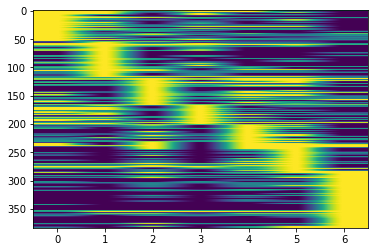

In [55]:
fig, ax = plt.subplots()
ax.imshow(roi_collection, aspect='auto')


In [56]:
import napari
viewer = napari.Viewer()
viewer.add_image(np.sum(master_map, axis=0), name='master_map')
for si in range(len(session_nums)):
    viewer.add_image(np.sum(session_maps[si], axis=0), name=f'session_{si}')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


# Quantify match rate between sessions

Text(0.5, 1.0, 'JK027 plane 3')

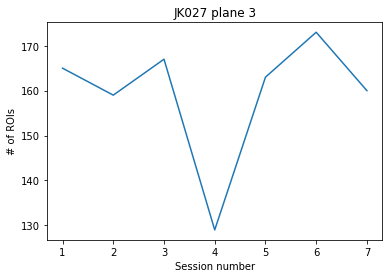

In [67]:
fig, ax = plt.subplots()
ax.plot(session_nums, np.sum(roi_collection, axis=0))
ax.set_xlabel('Session number')
ax.set_ylabel('# of ROIs')
ax.set_title(f'JK{mouse:03} plane {plane}')

Text(0.5, 1.0, 'JK027 plane 3')

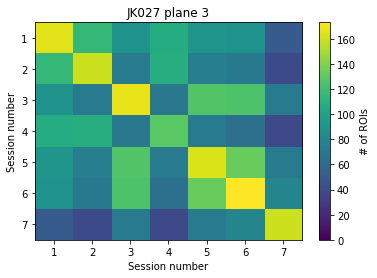

In [72]:
roi_matching_mat = np.zeros((len(session_nums), len(session_nums)))
for si in range(len(session_nums)):
    for sj in range(len(session_nums)):
        roi_matching_mat[si,sj] = np.sum(roi_collection[:,si] * roi_collection[:,sj], axis=0)
fig, ax = plt.subplots()
im = ax.imshow(roi_matching_mat, vmin=0, aspect='auto')
fig.colorbar(im, label='# of ROIs')
ax.set_xticks(np.arange(len(session_nums)))
ax.set_yticks(np.arange(len(session_nums)))
ax.set_xticklabels(session_nums)
ax.set_yticklabels(session_nums)
ax.set_xlabel('Session number')
ax.set_ylabel('Session number')
ax.set_title(f'JK{mouse:03} plane {plane}')

In [74]:
registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()
reg_result.keys()

dict_keys(['mouse', 'plane', 'edge_buffer', 'selected_session_i', 'selected_session_num', 'zdrift_list', 'registration_method', 'bilinear_result', 'affine_result', 'suite2p_result', 'old_result'])

In [81]:
reg_inds = [np.where(reg_result['selected_session_num'] == sn)[0][0] for sn in session_nums]
zdrift = [(np.min(reg_result['zdrift_list'][i]), np.max(reg_result['zdrift_list'][i])) for i in reg_inds]


[(23, 24), (22, 23), (27, 27), (21, 29), (25, 26), (26, 27), (30, 30)]

In [136]:

def plot_roi_collection(mouse, plane, base_dir):
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
    roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

    registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
    reg_result = np.load(registration_fn, allow_pickle=True).item()

    session_nums = master_roi['session_nums']
    matching_master_roi_ind = roi_collection_results['matching_master_roi_index_list']
    master_map = master_roi['master_map_list'][-1]
    session_maps = master_roi['session_map_list']
    selected_session_num = np.asarray(reg_result['selected_session_num']) # some has list, some has array

    roi_collection = np.zeros((master_map.shape[0], len(session_nums)), 'bool')
    for si in range(len(session_nums)):
        roi_collection[matching_master_roi_ind[si],si] = 1
    roi_matching_mat = np.zeros((len(session_nums), len(session_nums)))
    for si in range(len(session_nums)):
        for sj in range(len(session_nums)):
            roi_matching_mat[si,sj] = np.sum(roi_collection[:,si] * roi_collection[:,sj], axis=0)

    reg_inds = [np.where(selected_session_num == sn)[0][0] for sn in session_nums]
    zdrift = [(np.min(reg_result['zdrift_list'][i]), np.max(reg_result['zdrift_list'][i])) for i in reg_inds]

    fig, ax = plt.subplots(1,3, figsize=(17,5))
    ax[0].plot(session_nums, np.sum(roi_collection, axis=0))
    ax[0].set_xlabel('Session number')
    ax[0].set_ylabel('# of ROIs')

    im = ax[1].imshow(roi_matching_mat, vmin=0, aspect='auto')
    plt.colorbar(im, label='# of matched ROIs', ax=ax[1])
    ax[1].set_xticks(np.arange(len(session_nums)))
    ax[1].set_yticks(np.arange(len(session_nums)))
    ax[1].set_xticklabels(session_nums)
    ax[1].set_yticklabels(session_nums)
    ax[1].set_xlabel('Session number')
    ax[1].set_ylabel('Session number')

    ax[2].plot(session_nums, np.array(zdrift)[:,0], 'k-')
    ax[2].plot(session_nums, np.array(zdrift)[:,1], 'k-')
    ax[2].fill_between(session_nums, np.array(zdrift)[:,0], np.array(zdrift)[:,1])
    ax[2].set_xlabel('Session number')
    ax[2].set_ylabel('Z drift')

    fig.suptitle(f'JK{mouse:03} plane {plane}')
    fig.tight_layout()
    return fig, ax

In [137]:
save_dir = Path(r'E:\TPM\JK\h5\qc\roi_matching')
for mouse in mice:
    for plane in planes:
        save_fn = save_dir / f'JK{mouse:03}_plane{plane}_roi_collection.png'
        # if not save_fn.exists():
        fig, ax = plot_roi_collection(mouse, plane, base_dir)
        fig.savefig(save_fn)
        plt.close(fig)


# Enough number of ROIs matched between sessions
- Depth difference affects the # of matched neurons the most

# Do QC
- Look at some example matched neurons to see if they really matched
- Look at badly matched examples and see if the problem was with data itself or with transformation

In [130]:
def get_reg_img(reg_result):
    reg_meth = reg_result['registration_method']
    # Fix the error with suite2p method offsets (was collecting in a wrong way)
    # Match them with the 'old' method (2022/07/13 JK)
    if reg_meth == 'suite2p':
        reg_result = rcas.fix_reg_collection(reg_result)
    if reg_meth == 'old':
        reg_result_ops = reg_result['old_result']
    elif reg_meth == 'suite2p':
        reg_result_ops = reg_result['suite2p_result']
    elif reg_meth == 'affine':
        reg_result_ops = reg_result['affine_result']
    elif reg_meth == 'bilinear':
        reg_result_ops = reg_result['bilinear_result']
    else:
        raise('Registration method mismatch.')
    reg_img = reg_result_ops['reg_image']
    return reg_img

In [419]:
# Check transformed images and ROIs
mouse = 27
plane = 7
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

# reg_dir = Path(r'F:\\') / f'{mouse:03}' / f'plane_{plane}'
reg_dir = plane_dir

reg_fn = reg_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(reg_fn, allow_pickle=True).item()
reg_imgs = get_reg_img(reg_result)

session_nums = master_roi['session_nums']
selected_session_num = np.asarray(reg_result['selected_session_num']) # some has list, some has array
reg_inds = [np.where(selected_session_num == sn)[0][0] for sn in session_nums]
reg_imgs = [reg_imgs[ri] for ri in reg_inds]
session_rois = master_roi['session_map_list']

viewer = napari.Viewer()
for i in range(len(session_nums)):
    reg_img = reg_imgs[i]
    viewer.add_image(reg_img, name=f'session_{session_nums[i]}', visible=False)
    viewer.add_image(np.sum(session_rois[i], axis=0), 
                     name=f'session_{session_nums[i]}_roi',
                     visible=False)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [377]:
# Check its own images and ROIs
mouse = 27
plane = 7
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']

viewer = napari.Viewer()
# for i in range(len(session_nums)):
for i in range(5):
    session = session_nums[i]
    roi_dir = plane_dir / f'{session:03}' / f'plane0' / 'roi'
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    meanImg = ops['meanImg']
    viewer.add_image(meanImg, name=f'session_{session}', visible=False)
    roi_fn = roi_dir / f'final_roi_results_{mouse:03d}_plane_{plane}_{session:03d}_wo_dendrite_filtering.npy'
    roi = np.load(roi_fn, allow_pickle=True).item()
    final_mask = np.zeros(roi['final_mask'].shape)
    final_mask[np.where(roi['final_mask'] > 0)] = 1
    viewer.add_image(np.sum(final_mask, axis=2), 
                     name=f'session_{session}_roi',
                     visible=False)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [286]:
def get_reg_info(mouse, plane, base_dir):
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
    reg_result = np.load(registration_fn, allow_pickle=True).item()
    reg_meth = reg_result['registration_method']
    # Fix the error with suite2p method offsets (was collecting in a wrong way)
    # Match them with the 'old' method (2022/07/13 JK)
    if reg_meth == 'suite2p':
        reg_result = rcas.fix_reg_collection(reg_result)
    if reg_meth == 'old':
        reg_result_ops = reg_result['old_result']
        ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
        xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
    elif reg_meth == 'suite2p':
        reg_result_ops = reg_result['suite2p_result']
        ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
        xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
    elif reg_meth == 'affine':
        reg_result_ops = reg_result['affine_result']
    elif reg_meth == 'bilinear':
        reg_result_ops = reg_result['bilinear_result']
    else:
        raise('Registration method mismatch.')
    reg_img = reg_result_ops['reg_image']

    if reg_meth == 'old' or reg_meth == 'suite2p':
        top_edge = max(reg_result_ops['roff1'][0][0])+5 # Adding 5 for nonrigid and 2nd step registrations.
        bottom_edge = min(reg_result_ops['roff1'][0][0])-5
        left_edge = max(reg_result_ops['roff1'][0][1])+5
        right_edge = min(reg_result_ops['roff1'][0][1])-5
        registration_boundary = np.ones(reg_img.shape[1:], 'uint8')
        registration_boundary[top_edge:bottom_edge, left_edge:right_edge] = 0
    else:
        registration_boundary = np.sum(reg_img > 0,axis=0) < reg_img.shape[0]

    leftBuffer = reg_result['edge_buffer']['leftBuffer']
    topBuffer = reg_result['edge_buffer']['topBuffer']
    rightBuffer = reg_result['edge_buffer']['rightBuffer']
    bottomBuffer = reg_result['edge_buffer']['bottomBuffer']

    return reg_img, registration_boundary, leftBuffer, topBuffer, rightBuffer, bottomBuffer


def step_by_step_roi_maps(mouse, plane, snum, base_dir):
    reg_img, registration_boundary, leftBuffer, topBuffer, rightBuffer, bottomBuffer = \
        get_reg_info(mouse, plane, base_dir)
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    tempStat = np.load(plane_dir / f'{snum:03}/plane0/roi/stat.npy', allow_pickle=True)
    tempIscell = np.load(plane_dir / f'{snum:03}/plane0/roi/iscell.npy', allow_pickle=True)
    ops = np.load(plane_dir / f'{snum:03}/plane0/roi/ops.npy', allow_pickle=True).item()
    Ly, Lx = ops['Ly'], ops['Lx']

    if 'inmerge' in tempStat[0].keys():
        merged_ind = np.where([ts['inmerge']>0 for ts in tempStat])[0]
        if len(merged_ind) > 0:
            tempIscell[merged_ind,0] = 0
    tempCelli = np.where(tempIscell[:,0])[0]
    numCell = len(tempCelli)
    tempMap_og = np.zeros((numCell,Ly,Lx), 'bool')
    for n, ci in enumerate(tempCelli):
        xi = tempStat[ci]['xpix']
        yi = tempStat[ci]['ypix']
        tempMap_og[n,yi,xi] = 1

    # Remove ROIs overlapping with the registration buffer (for bidirectional noise and optotune ringing noise)
    registration_buffer = np.ones(tempMap_og.shape[1:], 'uint8')
    registration_buffer[topBuffer:-bottomBuffer, leftBuffer:-rightBuffer] = 0
    ind_remove_buffer = np.where(np.sum((tempMap_og * registration_buffer), axis=(1,2)))[0]
    tempMap_reg_buffer_filtered = np.delete(tempMap_og, ind_remove_buffer, axis=0)
    tempMap_reg_buffer_filtered = tempMap_reg_buffer_filtered[:,topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
    
    # remove ROIs overlappting with the registration boundary.
    # (a little chopped-off ROI could still remain and be transformed.)
    ind_remove_boundary = np.where(np.sum((tempMap_reg_buffer_filtered * registration_boundary), axis=(1,2)))[0]
    tempMap_reg_boundary_filtered = np.delete(tempMap_reg_buffer_filtered, ind_remove_boundary, axis=0)
    
    return tempMap_og, tempMap_reg_buffer_filtered, tempMap_reg_boundary_filtered

In [305]:
mouse = 25
plane = 7
snum = 2
map_og, map_reg_buffer_filtered, map_reg_boundary_filtered = step_by_step_roi_maps(mouse, plane, snum, base_dir)

In [306]:
viewer = napari.Viewer()
viewer.add_image(np.sum(map_og, axis=0), name='og')
viewer.add_image(np.sum(map_reg_buffer_filtered, axis=0), name='buffer_filtered')
viewer.add_image(np.sum(map_reg_boundary_filtered, axis=0), name='boundary_filtered')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'boundary_filtered' at 0x20e80e7e0a0>

In [289]:
reg_img, registration_boundary, leftBuffer, topBuffer, rightBuffer, bottomBuffer = \
        get_reg_info(mouse, plane, base_dir)

In [299]:
viewer = napari.Viewer()
viewer.add_image(reg_img, name='reg_img')
viewer.add_image(registration_boundary, contrast_limits=[0,1], name='boundary')


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'boundary' at 0x20ea15ac2b0>

### Checking JK027 plane 4 errors
- Files in the ROI dir look good.
- Individual ROI maps transformation look good.
- Which means session_to_session_registration is good.
    - Maybe I already copied over from HDD.
- Re-run roi collection and matching back.

In [363]:
# Re-run roi collection and matching back
mouse = 27
plane = 4
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
session_nums = master_roi['session_nums']
rcas.run_roi_collection_and_match_back(mouse, plane, session_nums, base_dir)

ROI collection: JK027 plane 4
Processing JK027 plane 4 027_001 0/7
027_001 done.
Processing JK027 plane 4 027_002 1/7
Delete from Master [0, 1, 57, 40, 9, 18, 151, 42, 61, 43, 6, 55, 29, 30, 155, 15, 169, 5, 32, 27, 98, 102, 148, 165, 47, 37, 60, 39, 88, 51, 168, 8, 49, 128, 46, 101, 108, 45, 76, 95, 2, 143, 53, 66, 91, 71, 105, 72, 110, 73, 70, 13, 77, 23, 116, 36, 150, 172, 26, 176, 164, 173, 138, 31, 114, 41, 123, 115, 121, 135, 178, 54, 99, 146]
Delete from New [2, 5, 6, 7, 12, 15, 16, 17, 21, 23, 24, 27, 28, 29, 30, 32, 33, 39, 42, 43, 46, 48, 57, 60, 62, 63, 64, 66, 67, 74, 76, 78, 80, 86, 87, 88, 89, 91, 92, 95, 96, 97, 104, 107, 109, 110, 120, 121, 122, 124, 127, 129, 131, 132, 138, 140, 141, 154, 160, 161, 165, 168, 170, 171, 177, 180, 181, 182, 183, 184, 185, 187, 188, 190]
027_002 done.
Processing JK027 plane 4 027_003 2/7
Delete from Master [82, 82, 196, 148, 9, 47, 106, 53, 36, 24, 134, 7, 206, 30, 18, 79, 127, 95, 38, 189, 209, 153, 185, 71, 48, 110, 12, 187, 203, 159, 90

In [308]:
reload(rcas)

<module 'scripts.roi_collection_across_sessions' from 'c:\\Users\\shires\\Dropbox\\Works\\Projects\\2020 Neural stretching in S1\\Analysis\\codes\\scripts\\roi_collection_across_sessions.py'>

In [309]:
rcas.run_roi_matching(mouse, plane, base_dir)

Re-matching with master ROI map: JK027 plane 4
Processing re-matching JK027 plane 4 027_001 0/6
Processing re-matching JK027 plane 4 027_002 1/6
Processing re-matching JK027 plane 4 027_003 2/6
Processing re-matching JK027 plane 4 027_004 3/6
Processing re-matching JK027 plane 4 027_005 4/6
Processing re-matching JK027 plane 4 027_006 5/6
Processing re-matching JK027 plane 4 027_007 6/6
JK027 plane 4 saved.


### Now it almost works fine after re-running.
- But session 4 ROI transform is wrong.

In [333]:
registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()

In [313]:
reg_result

{'mouse': 27,
 'plane': 4,
 'edge_buffer': {'leftBuffer': 30,
  'rightBuffer': 30,
  'bottomBuffer': 10,
  'topBuffer': 50},
 'selected_session_i': array([ 0,  1,  2,  3,  4,  5,  6, 12], dtype=int64),
 'selected_session_num': array([ 1,  2,  3,  4,  5,  6,  7, 25]),
 'zdrift_list': [array([24, 24, 24, 24, 23, 23, 23, 23, 23, 23], dtype=int64),
  array([23, 23, 23, 23, 23, 23, 23, 22], dtype=int64),
  array([27, 27, 27, 27, 27], dtype=int64),
  array([23, 23, 23, 23, 27, 29, 21, 22], dtype=int64),
  array([26, 26, 26, 26, 26, 25], dtype=int64),
  array([27, 27, 26, 26], dtype=int64),
  array([30, 30, 30], dtype=int64),
  array([30, 30, 30, 30, 30, 30, 29, 29, 29], dtype=int64)],
 'registration_method': 'bilinear',
 'bilinear_result': {'reg_image': array([[[3842.66644287, 4064.50823975, 4354.7722168 , ...,
           1540.90472412, 1514.49609375, 1509.09805298],
          [3789.4576416 , 3988.57763672, 4271.81109619, ...,
           1533.01086426, 1514.95877075, 1516.83325195],
        

In [314]:
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
session_nums = master_roi['session_nums']

In [320]:
viewer.add_image(np.sum(master_roi['master_map_list'][-1], axis=0))

<Image layer 'Image [1]' at 0x20e995e6610>

In [334]:
snum = 4
ops = np.load(plane_dir / f'{snum:03}/plane0/roi/ops.npy', allow_pickle=True).item()
meanImg = ops['meanImg']


reg_meth = reg_result['registration_method']
# Fix the error with suite2p method offsets (was collecting in a wrong way)
# Match them with the 'old' method (2022/07/13 JK)
if reg_meth == 'suite2p':
    reg_result = rcas.fix_reg_collection(reg_result)

# Retrieve buffers, options, and dimensions
if reg_meth == 'old':
    reg_result_ops = reg_result['old_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'suite2p':
    reg_result_ops = reg_result['suite2p_result']
    ybuffer = max(abs(reg_result_ops['roff1'][0][0]))
    xbuffer = max(abs(reg_result_ops['roff1'][0][1]))
elif reg_meth == 'affine':
    reg_result_ops = reg_result['affine_result']
elif reg_meth == 'bilinear':
    reg_result_ops = reg_result['bilinear_result']
else:
    raise('Registration method mismatch.')

srBi = StackReg(StackReg.BILINEAR)
srAffine = StackReg(StackReg.AFFINE)

leftBuffer = reg_result['edge_buffer']['leftBuffer']
topBuffer = reg_result['edge_buffer']['topBuffer']
rightBuffer = reg_result['edge_buffer']['rightBuffer']
bottomBuffer = reg_result['edge_buffer']['bottomBuffer']

si = np.where(np.asarray(reg_result['selected_session_num']) == snum)[0][0]

if (reg_meth == 'old') or (reg_meth == 'suite2p'):
    rigid_y1 = reg_result_ops['roff1'][0][0][si]
    rigid_x1 = reg_result_ops['roff1'][0][1][si]
    nonrigid_y1 = reg_result_ops['nroff1'][0][0][si]
    nonrigid_x1 = reg_result_ops['nroff1'][0][1][si]
    
    rigid_y2 = reg_result_ops['roff2'][0][0][si]
    rigid_x2 = reg_result_ops['roff2'][0][1][si]
    nonrigid_y2 = reg_result_ops['nroff2'][0][0][si]
    nonrigid_x2 = reg_result_ops['nroff2'][0][1][si]

    block_size1 = reg_result_ops['block_size1']
    block_size2 = reg_result_ops['block_size2']

meanImg_cropped = meanImg[topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
if (reg_meth == 'old') or (reg_meth == 'suite2p'):
    tempRegMap = rcas.twostep_register(meanImg_cropped, rigid_y1, rigid_x1, nonrigid_y1, nonrigid_x1, block_size1, 
                    rigid_y2, rigid_x2, nonrigid_y2, nonrigid_x2, block_size2)
elif reg_meth == 'affine':
    tempRegMap = srAffine.transform(meanImg_cropped, tmat=reg_result_ops['tforms'][si])
elif reg_meth == 'bilinear':
    tempRegMap = srBi.transform(meanImg_cropped, tmat=reg_result_ops['tforms'][si])
else:
    raise('Registration method mismatch')    

In [335]:
viewer.add_image(tempRegMap)

<Image layer 'tempRegMap [2]' at 0x20e677ff100>

In [337]:
reg_result.keys()

dict_keys(['mouse', 'plane', 'edge_buffer', 'selected_session_i', 'selected_session_num', 'zdrift_list', 'registration_method', 'bilinear_result', 'affine_result', 'suite2p_result', 'old_result'])

In [342]:
viewer.add_image(reg_result['bilinear_result']['reg_image'][3])

<Image layer 'Image' at 0x20e7e12cf10>

In [326]:
viewer.add_image(meanImg)

<Image layer 'meanImg' at 0x20e720dfd90>

### ROI transformation is the same as re-transformation of meanImg
- But somehow the transformation does not match with any of the sessions, including its own previous transformation.
- Re-run session_to_session_registration
    - It resulted in still another different registration.

In [344]:
viewer2 = napari.Viewer()
for img in reg_result['bilinear_result']['reg_image']:
    img[np.where(np.isnan(img))] = 0
    viewer2.add_image(img)

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


### JK027 plane4 session_to_session_registration check

In [345]:
import scripts.session_to_session_registration as ssr

c:\Users\shires\Dropbox\Works\Projects\2020 Neural stretching in S1\Analysis\codes\scripts\session_to_session_registration.py:54: RuntimeWarning: invalid value encountered in subtract
  newimg = (img - np.amin(img)) / (np.amax(img) - np.amin(img))


In [359]:
mouse = 27
pn = 4

reg_meth = 'bilinear'
selDepthsRV = [20, 30]
manRmvSi = range(7,12)
refSn = 3

prevN = 3

if pn < 5:
    vi = 0 # volume index, either 1 or 5
    vn = 1
else:
    vi = 1
    vn = 5
    
zdrift = np.load(base_dir / f"JK{mouse:03}_zdrift_plane{vn}.npy", allow_pickle=True).item()


siArr = np.where([len(sn.split('_'))==2 for sn in zdrift['info']['sessionNames']])[0]
snums = np.array([int(sn.split('_')[1]) for sn in zdrift['info']['sessionNames'] if len(sn.split('_'))==2])
siSorted = siArr[np.argsort(snums)]

# Select sessions
selectedSi = np.array([si for si in siSorted if \
            sum(np.logical_and(zdrift['zdriftList'][si]>=selDepthsRV[0], zdrift['zdriftList'][si]<=selDepthsRV[1])) >=3 ])
selectedSnums = [int(sname.split('_')[1]) for sname in np.array(zdrift['info']['sessionNames'])[selectedSi]]

if len(manRmvSi)>0:
    selectedSi = np.delete(selectedSi, manRmvSi)
    selectedSnums = np.delete(selectedSnums, manRmvSi)

zdrift_list = [zdrift['zdriftList'][si] for si in selectedSi]

# To deal with the rolling effect of suite2p within-session registration
leftBuffer = 30
rightBuffer = 30 if mouse < 50 else 100
bottomBuffer = 10
topBuffer = 50

edge_buffer = {'leftBuffer': leftBuffer,
            'rightBuffer': rightBuffer,
            'bottomBuffer': bottomBuffer,
            'topBuffer': topBuffer}

planeDir = base_dir / f'{mouse:03}/plane_{pn}/'

numSelected = len(selectedSi)
mimgs = []
mimgClahe = []
refOld = []
for si, sn in enumerate(selectedSnums):
    opsFn = plane_dir / f'{sn:03}/plane0/ops.npy'
    ops = np.load(opsFn, allow_pickle=True).item()
    mimg = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
    mimgs.append(mimg)
    mimgClahe.append(ssr.clahe_each(mimg))
    if sn == refSn:
        refOld = ops['meanImg'][topBuffer:-bottomBuffer,leftBuffer:-rightBuffer]
if len(refOld) == 0:
    raise('Reference session image not defined (for old reg method).')


mimgs = np.moveaxis(np.dstack(mimgs), -1, 0)
mimgClahe = np.moveaxis(np.dstack(mimgClahe), -1, 0)

In [351]:
selectedSi

array([ 0,  1,  2,  3,  4,  5,  6, 12], dtype=int64)

In [361]:
regBi = np.zeros_like(mimgs)
tformsBi = []
for si in range(numSelected):
    if si == 0:
        regBi[si,:,:] = mimgs[si,:,:]
        tformsBi.append(np.eye(4))
    else:
        previStart = max(0,si-prevN)
        refBi = ssr.clahe_each(np.mean(regBi[previStart:si,:,:], axis=0))
        tform = srBi.register(refBi, mimgClahe[si,:,:])
        regBi[si,:,:] = srBi.transform(mimgs[si,:,:], tmat=tform)
        tformsBi.append(tform)

In [362]:
viewer = napari.Viewer()
viewer.add_image(regBi)

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'regBi' at 0x20ef0052e20>

In [354]:
regBi = np.zeros_like(mimgs)
tformsBi = []

In [ ]:
si = 0
regBi[si,:,:] = mimgs[si,:,:]
tformsBi.append(np.eye(4))

### JK027 session 4 ROI transformation error (planes 2,5, and 7)
- Registraiton itself worked well (no error in session_to_session_registration.npy)
- ROI maps look matched to meanImg without transformation
- Could mean that master map generation had wrong files to work with. 

In [416]:
# Re-run roi collection and matching back
mouse = 27
base_dir = Path(r'E:\TPM\JK\h5')

for plane in [2,5,7]:
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
    master_roi = np.load(master_roi_fn, allow_pickle=True).item()
    session_nums = master_roi['session_nums']
    rcas.run_roi_collection_and_match_back(mouse, plane, session_nums, base_dir)

ROI collection: JK027 plane 2
Processing JK027 plane 2 027_001 0/7
027_001 done.
Processing JK027 plane 2 027_002 1/7
Delete from Master [5, 133, 28, 9, 71, 18, 0, 6, 22, 33, 14, 8, 54, 51, 3, 106, 53, 4, 104, 80, 23, 100, 82, 29, 87, 118, 102, 37, 126, 107, 135, 103, 129, 1, 68, 131, 123, 113, 70, 57]
Delete from New [1, 5, 8, 11, 13, 15, 16, 22, 23, 24, 25, 27, 28, 29, 30, 31, 33, 35, 36, 38, 41, 42, 43, 44, 45, 46, 51, 53, 55, 56, 57, 60, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 78, 81, 82, 84, 86, 87, 88, 93, 101, 103, 106, 107, 111, 114, 116, 118, 120, 123]
027_002 done.
Processing JK027 plane 2 027_003 2/7
Delete from Master [150, 0, 18, 4, 159, 105, 52, 111, 80, 19, 63, 81, 47, 138, 75, 92, 147, 89, 67, 154, 51, 8, 164, 157, 41, 124, 38, 119, 55, 42, 91, 125, 107, 37, 88, 76, 94, 137, 85, 142, 74, 140, 83]
Delete from New [1, 3, 4, 6, 7, 8, 10, 11, 13, 14, 15, 16, 18, 33, 38, 40, 41, 44, 47, 48, 51, 52, 54, 56, 73, 78, 79, 82, 84, 93, 100, 108, 113, 117, 125, 129, 130, 131, 1

Re-running ROI collection worked for plane 4 session 4, <br>
but not for session 4 in planes 2,5, and 7
- Look at the roi_collection code line by line

In [409]:
mouse = 27
plane = 2

# base_dir = Path(r'F:')
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
registration_fn = plane_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(registration_fn, allow_pickle=True).item()
session_nums = reg_result['selected_session_num']
reg_meth = reg_result['registration_method']
print(reg_meth)

bilinear


In [401]:
print(session_nums)

[ 1  2  3  4  5  6  7 25]


In [410]:
reg_result_ops = reg_result['bilinear_result']
reg_img = reg_result_ops['reg_image']
Ly, Lx = reg_img.shape[1:]
print(reg_img.shape)

(8, 327, 627)


In [403]:
# Check the registration
viewer = napari.Viewer()
viewer.add_image(reg_img)

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'reg_img' at 0x20e68fca0a0>

In [411]:
srBi = StackReg(StackReg.BILINEAR)
leftBuffer = reg_result['edge_buffer']['leftBuffer']
topBuffer = reg_result['edge_buffer']['topBuffer']
rightBuffer = reg_result['edge_buffer']['rightBuffer']
bottomBuffer = reg_result['edge_buffer']['bottomBuffer']

In [412]:
# Look at the transformation of a specific session in this plane
snum = 4

tempStat = np.load(plane_dir / f'{snum:03}/plane0/roi/stat.npy', allow_pickle=True)
tempIscell = np.load(plane_dir / f'{snum:03}/plane0/roi/iscell.npy', allow_pickle=True)
ops = np.load(plane_dir / f'{snum:03}/plane0/roi/ops.npy', allow_pickle=True).item()
Ly, Lx = ops['Ly'], ops['Lx']

if 'inmerge' in tempStat[0].keys():
    merged_ind = np.where([ts['inmerge']>0 for ts in tempStat])[0]
    if len(merged_ind) > 0:
        tempIscell[merged_ind,0] = 0
tempCelli = np.where(tempIscell[:,0])[0]
numCell = len(tempCelli)
tempMap = np.zeros((numCell,Ly,Lx), 'bool')
for n, ci in enumerate(tempCelli):
    xi = tempStat[ci]['xpix']
    yi = tempStat[ci]['ypix']
    tempMap[n,yi,xi] = 1

In [405]:
# Check the match between mean Img and ROI map
viewer = napari.Viewer()
viewer.add_image(np.sum(tempMap, axis=0), name='original')
viewer.add_image(ops['meanImg'])

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'Image' at 0x20e99274550>

In [413]:
# Remove ROIs overlapping with the registration buffer (for bidirectional noise and optotune ringing noise)
registration_buffer = np.ones(tempMap.shape[1:], 'uint8')
registration_buffer[topBuffer:-bottomBuffer, leftBuffer:-rightBuffer] = 0
ind_remove_buffer = np.where(np.sum((tempMap * registration_buffer), axis=(1,2)))[0]
tempMap = np.delete(tempMap, ind_remove_buffer, axis=0)
tempCelli = np.delete(tempCelli, ind_remove_buffer)
tempMap = tempMap[:,topBuffer:-bottomBuffer, leftBuffer:-rightBuffer]
# session_og_map_list.append(tempMap)

# remove ROIs overlappting with the registration boundary.
# (a little chopped-off ROI could still remain and be transformed.)
ind_remove_boundary = np.where(np.sum((tempMap * registration_boundary), axis=(1,2)))[0]
tempMap = np.delete(tempMap, ind_remove_boundary, axis=0)
tempCelli = np.delete(tempCelli, ind_remove_boundary)
numCell = len(tempCelli)

In [395]:
# Check the match between mean Img and ROI map
viewer = napari.Viewer()
viewer.add_image(ops['meanImg'][topBuffer:-bottomBuffer, leftBuffer:-rightBuffer])
viewer.add_image(np.sum(tempMap, axis=0), name='original')


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'original' at 0x20e72b5c970>

In [414]:
# Transform and cut ROIs
si = np.where(np.asarray(session_nums) == snum)[0][0]
tmat = reg_result_ops['tforms'][si]
tempRegMap = np.zeros(tempMap.shape)
for trmi in range(tempRegMap.shape[0]):
    tempRegMap[trmi,:,:] = srBi.transform(tempMap[trmi,:,:], tmat=tmat)

cutMap = np.zeros((numCell, *reg_img.shape[1:]), 'bool')
delFromCut = []
warpCellThresh = np.zeros(numCell)
after_transform_boundary = np.ones(tempRegMap.shape[1:])
after_transform_boundary[1:-1,1:-1] = 0
for ci in range(numCell):
    numPix = np.sum(tempMap[ci,:,:])
    cutMap[ci,:,:], warpCellThresh[ci] = rcas.calculate_regCell_threshold(tempRegMap[ci,:,:], numPix, thresholdResolution = 0.01)
    # Remove ROIs that have crossed the boundary
    # or that have 0 pixels after cutting with threshold
    if (np.sum(cutMap[ci,:,:])==0) or ((cutMap[ci,:,:] * after_transform_boundary).flatten().any()):
        delFromCut.append(ci)
# session_cut_map_list.append(cutMap)
if len(delFromCut) > 0:
    cutMap = np.delete(cutMap, np.array(delFromCut), axis=0)
    viable_cell_index = np.delete(tempCelli, np.array(delFromCut))
    numCell -= len(delFromCut)
else:
    viable_cell_index = tempCelli

if cutMap.shape[0] != numCell:
    raise('# of cell mismatch error.')

In [415]:
# Compare the transformed ROI map to the registered image
viewer = napari.Viewer()
viewer.add_image(reg_img)
viewer.add_image(np.sum(cutMap, axis=0), name='transformed')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Image layer 'transformed' at 0x20e690bee50>

### Transformation matrix seems to be wrong
- Even the one from the HDD
- Need to re-run the session_to_session_registration
    - Took pretty fast
- Now it looks good


# JK052 volume 1 errors
- session 7
- session 13 plane 2,3

In [422]:
# Check transformed images and ROIs
mouse = 52
plane = 3
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()
cp_roi_collection_results_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_roi_session_to_master.npy'
roi_collection_results = np.load(cp_roi_collection_results_fn, allow_pickle=True).item()

# reg_dir = Path(r'F:\\') / f'{mouse:03}' / f'plane_{plane}'
reg_dir = plane_dir

reg_fn = reg_dir / f'JK{mouse:03}_plane{plane}_session_to_session_registration.npy'
reg_result = np.load(reg_fn, allow_pickle=True).item()
reg_imgs = get_reg_img(reg_result)

session_nums = master_roi['session_nums']
selected_session_num = np.asarray(reg_result['selected_session_num']) # some has list, some has array
reg_inds = [np.where(selected_session_num == sn)[0][0] for sn in session_nums]
reg_imgs = [reg_imgs[ri] for ri in reg_inds]
session_rois = master_roi['session_map_list']

viewer = napari.Viewer()
for i in range(len(session_nums)):
    reg_img = reg_imgs[i]
    viewer.add_image(reg_img, name=f'session_{session_nums[i]}', visible=False)
    viewer.add_image(np.sum(session_rois[i], axis=0), 
                     name=f'session_{session_nums[i]}_roi',
                     visible=False)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


### solution
- Remove session 7 from volume 1
- Session 13 was pretty stable in z-motion. Leave it.

# JK052 tdTomato issue
- Increasing number of ROIs, due to increased expression of tdTomato
- Potential solution:
    - Cut off using skewness threshold. Going to remove nonactive neurons even though it was observable.
        - This one sounds better. Disregard nonactive neurons.
    - Cut off the same # of neurons by sorted skewness. 
# I don't need this, actually
- Ignore this part of process for now (2024/01/29)

In [425]:
# Get skewness data from different mice and planes
# Look at their distribution
mi = 0
pi = 0
si = 0
mice = use_mice_df.mouse.unique()
planes = np.arange(1,9)
mouse = mice[mi]
plane = planes[pi]
session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
si = 0
session_name = session_names[si]
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
roi_dir = plane_dir / f'{session_name}/plane0/roi'
stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)


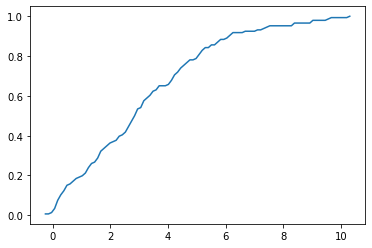

In [431]:
skews = [s['skew'] for s in stats]
hist_skew = np.histogram(skews, bins=100)
cum_hist = np.cumsum(hist_skew[0])/len(skews)
fig, ax = plt.subplots()
ax.plot(hist_skew[1][:-1], cum_hist)

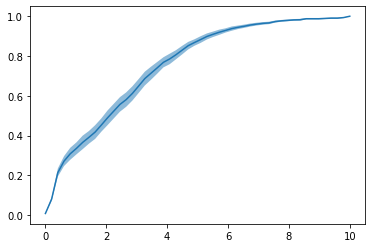

In [435]:
# aggregate from one plane across sessions
bins = [-10, *np.linspace(0, 10, 50)[:-1], 100]
xrange = np.linspace(0, 10, 50)
cum_hist_plane = []
for session_name in session_names:
    roi_dir = plane_dir / f'{session_name}/plane0/roi'
    stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
    skews = [s['skew'] for s in stats]
    hist_skew = np.histogram(skews, bins=bins)
    cum_hist = np.cumsum(hist_skew[0])/len(skews)
    cum_hist_plane.append(cum_hist)
cum_hist_plane = np.asarray(cum_hist_plane)
cum_hist_mean = np.mean(cum_hist_plane, axis=0)
cum_hist_sem = np.std(cum_hist_plane, axis=0) / np.sqrt(len(session_names))
fig, ax = plt.subplots()
ax.plot(xrange, cum_hist_mean)
ax.fill_between(xrange, cum_hist_mean-cum_hist_sem, cum_hist_mean+cum_hist_sem, alpha=0.5)



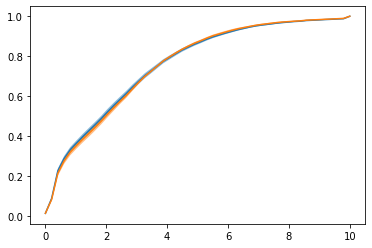

In [443]:
# aggregate across sessions, and mice
# except for JK052
pi = 0
bins = [-10, *np.linspace(0, 10, 50)[:-1], 100]
xrange = np.linspace(0, 10, 50)
cum_hist_plane_all = []
cum_hist_mean_mouse = []
plane = planes[pi]
for mouse in mice:
    if mouse != 52:
        cum_hist_plane = []
        session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
        for session_name in session_names:
            plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
            roi_dir = plane_dir / f'{session_name}/plane0/roi'
            stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
            skews = [s['skew'] for s in stats]
            hist_skew = np.histogram(skews, bins=bins)
            cum_hist = np.cumsum(hist_skew[0])/len(skews)
            cum_hist_plane.append(cum_hist)
            cum_hist_plane_all.append(cum_hist)
        cum_hist_plane = np.asarray(cum_hist_plane)
        cum_hist_mean = np.mean(cum_hist_plane, axis=0)
        cum_hist_mean_mouse.append(cum_hist_mean)
cum_hist_plane_all = np.asarray(cum_hist_plane_all)
cum_hist_plane_mean = np.mean(cum_hist_plane_all, axis=0)
cum_hist_plane_sem = np.std(cum_hist_plane_all, axis=0) / np.sqrt(len(mice)*len(planes))
cum_hist_mean_mouse = np.asarray(cum_hist_mean_mouse)
cum_hist_mean = np.mean(cum_hist_mean_mouse, axis=0)
cum_hist_sem = np.std(cum_hist_mean_mouse, axis=0) / np.sqrt(len(mice))
fig, ax = plt.subplots()
ax.plot(xrange, cum_hist_plane_mean)
ax.fill_between(xrange, cum_hist_plane_mean-cum_hist_plane_sem, cum_hist_plane_mean+cum_hist_plane_sem, alpha=0.5)
ax.plot(xrange, cum_hist_mean)
ax.fill_between(xrange, cum_hist_mean-cum_hist_sem, cum_hist_mean+cum_hist_sem, alpha=0.5)

Text(0.5, 1.0, 'plane 1')

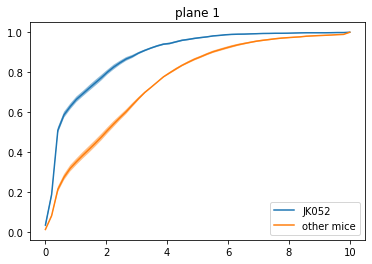

In [445]:
# compare with JK052
pi = 0
bins = [-10, *np.linspace(0, 10, 50)[:-1], 100]
xrange = np.linspace(0, 10, 50)
plane = planes[pi]
mouse = 52
cum_hist_plane_52 = []
session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
for session_name in session_names:
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    roi_dir = plane_dir / f'{session_name}/plane0/roi'
    stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
    skews = [s['skew'] for s in stats]
    hist_skew = np.histogram(skews, bins=bins)
    cum_hist = np.cumsum(hist_skew[0])/len(skews)
    cum_hist_plane_52.append(cum_hist)
cum_hist_plane_52 = np.asarray(cum_hist_plane_52)
cum_hist_mean_52 = np.mean(cum_hist_plane_52, axis=0)
cum_hist_sem_52 = np.std(cum_hist_plane_52, axis=0) / np.sqrt(len(session_names))
fig, ax = plt.subplots()
ax.plot(xrange, cum_hist_mean_52, label='JK052')
ax.fill_between(xrange, cum_hist_mean_52-cum_hist_sem_52, cum_hist_mean_52+cum_hist_sem_52, alpha=0.5)
ax.plot(xrange, cum_hist_mean, label='other mice')
ax.fill_between(xrange, cum_hist_mean-cum_hist_sem, cum_hist_mean+cum_hist_sem, alpha=0.5)
ax.legend()
ax.set_title(f'plane {plane}')

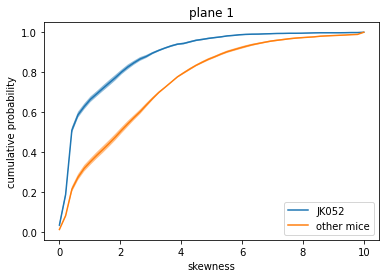

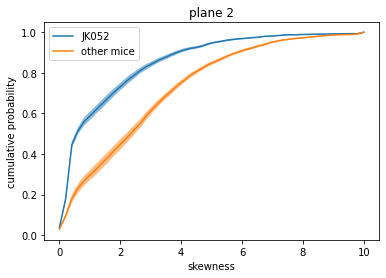

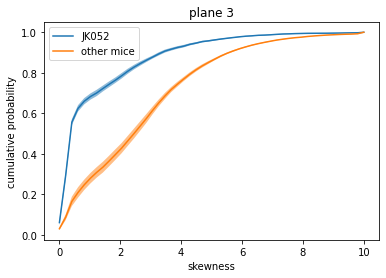

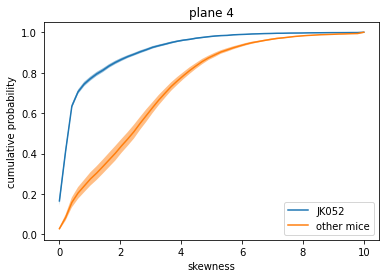

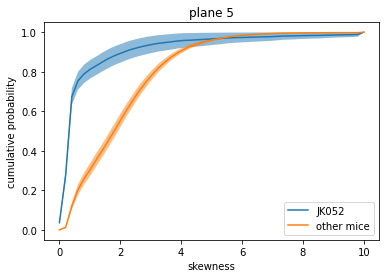

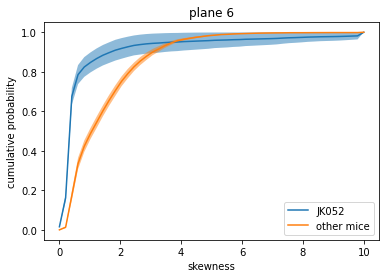

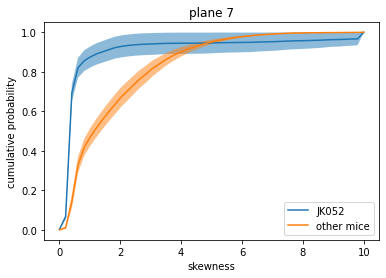

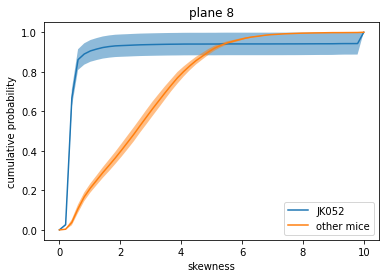

In [447]:
# do the same thing across planes
# to see if there is any plane bias
bins = [-10, *np.linspace(0, 10, 50)[:-1], 100]
xrange = np.linspace(0, 10, 50)

for plane in planes:
    cum_hist_mean_other_mice = []
    for mouse in mice:
        cum_hist_plane = []
        session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
        for session_name in session_names:
            plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
            roi_dir = plane_dir / f'{session_name}/plane0/roi'
            stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
            skews = [s['skew'] for s in stats]
            hist_skew = np.histogram(skews, bins=bins)
            cum_hist = np.cumsum(hist_skew[0])/len(skews)
            cum_hist_plane.append(cum_hist)
        cum_hist_plane = np.asarray(cum_hist_plane)
        cum_hist_mean = np.mean(cum_hist_plane, axis=0)
        if mouse != 52:
            cum_hist_mean_other_mice.append(cum_hist_mean)
        else:
            cum_hist_plane_52 = np.asarray(cum_hist_plane)
            cum_hist_mean_52 = np.mean(cum_hist_plane_52, axis=0)
            cum_hist_sem_52 = np.std(cum_hist_plane_52, axis=0) / np.sqrt(len(session_names))
    cum_hist_mean_other_mice = np.asarray(cum_hist_mean_other_mice)
    cum_hist_mom_mean = np.mean(cum_hist_mean_other_mice, axis=0)
    cum_hist_mom_sem = np.std(cum_hist_mean_other_mice, axis=0) / np.sqrt(len(mice))

    fig, ax = plt.subplots()
    ax.plot(xrange, cum_hist_mean_52, label='JK052')
    ax.fill_between(xrange, cum_hist_mean_52-cum_hist_sem_52, cum_hist_mean_52+cum_hist_sem_52, alpha=0.5)
    ax.plot(xrange, cum_hist_mom_mean, label='other mice')
    ax.fill_between(xrange, cum_hist_mom_mean-cum_hist_mom_sem, cum_hist_mom_mean+cum_hist_mom_sem, alpha=0.5)
    ax.legend()
    ax.set_title(f'plane {plane}')
    ax.set_xlabel('skewness')
    ax.set_ylabel('cumulative probability')
    


In [562]:
# Compare threshold values across planes from other mice
# varying percentile - 1, 2, 5, and 10
# if the threshold is significantly different, apply per plane
# if not, apply a global threshold

# use absolute skew value
# re-run after correcting skew using F_reduced only (2024/01/27 JK)
# stat_reduced.npy
bins = [*np.linspace(0, 10, 1000), 100]

cum_hist_allplanes = []
for plane in planes:
    cum_hist_mean = []
    for mouse in mice:
        if mouse != 52:
            cum_hist_plane = []
            session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
            for session_name in session_names:
                plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
                roi_dir = plane_dir / f'{session_name}/plane0/roi'
                stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
                skews = [abs(s['skew']) for s in stats]
                hist_skew = np.histogram(skews, bins=bins)
                cum_hist = np.cumsum(hist_skew[0])/len(skews)
                cum_hist_plane.append(cum_hist)
            cum_hist_plane = np.asarray(cum_hist_plane)
            cum_hist_mean.append(np.mean(cum_hist_plane, axis=0))
    cum_hist_mean = np.asarray(cum_hist_mean)
    cum_hist_allplanes.append(cum_hist_mean)



In [563]:
# linear interpolation
from scipy.interpolate import interp1d
percentile_thresholds = [0.02, 0.05, 0.1]
skew_thresh_all = []
for pi in range(8):
    skew_thresh_plane = []
    for mi in range(5):
        x = [0, *cum_hist_allplanes[pi][mi]]
        y = [*np.linspace(0, 10, 1000), 100]
        interp_func = interp1d(x, y)
        skew_thresh_plane.append(interp_func(percentile_thresholds))
    skew_thresh_all.append(np.asarray(skew_thresh_plane))

Text(0, 0.5, 'skewness threshold')

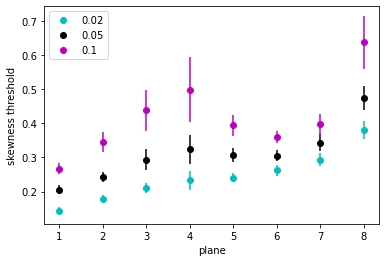

In [564]:
fig, ax = plt.subplots()
colors = ['c', 'k', 'm']
for i in range(3):
    for pi in range(8):
        thresh_vals = skew_thresh_all[pi][:,i]
        if pi == 0:
            ax.plot(pi+1, np.mean(thresh_vals), 'o', color=colors[i], label=f'{percentile_thresholds[i]}')
        else:
            ax.plot(pi+1, np.mean(thresh_vals), 'o', color=colors[i])        
        ax.errorbar(pi+1, np.mean(thresh_vals), np.std(thresh_vals)/np.sqrt(5), color=colors[i])
ax.legend()
ax.set_xlabel('plane')
ax.set_ylabel('skewness threshold')

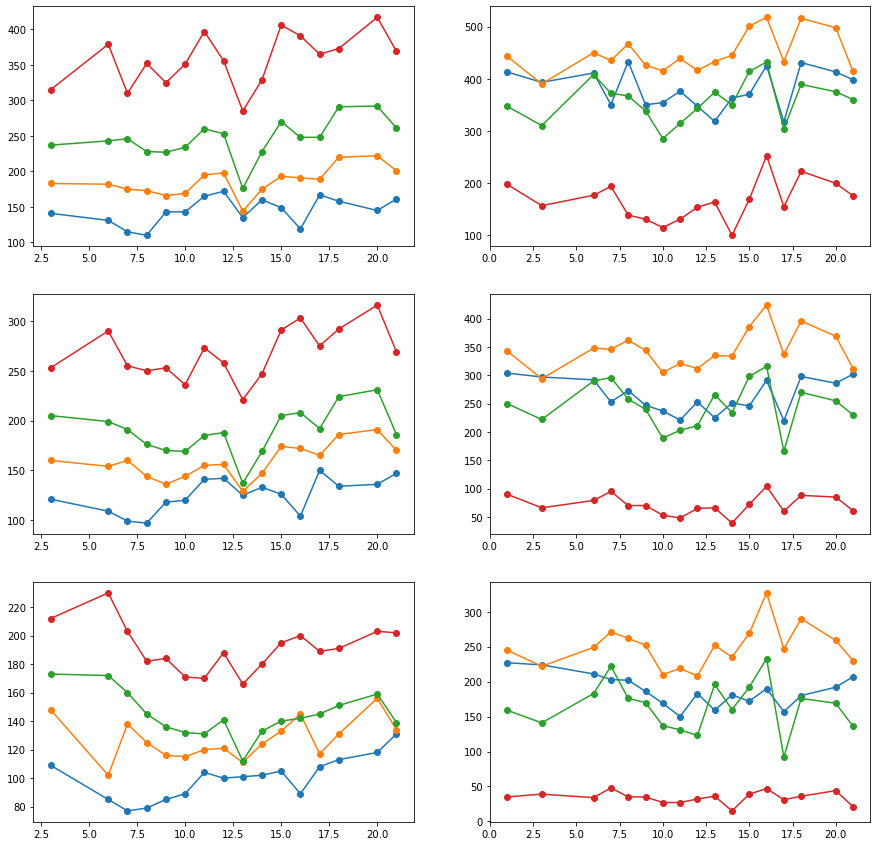

In [586]:
# calculate # of ROIs above the threshold
# For each threshold
# For each plane
mouse = 52
fig, ax = plt.subplots(3,2, figsize=(15,15))
for pi in range(8):
    if pi < 4:
        ax_ix = 0
    else:
        ax_ix = 1
    skew_thresholds = np.mean(skew_thresh_all[pi], axis=0)
    plane = planes[pi]
    session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
    num_above_threshold = np.zeros((len(session_names), len(percentile_thresholds)))
    for si, session_name in enumerate(session_names):
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
        roi_dir = plane_dir / f'{session_name}/plane0/roi'
        stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
        skews = np.array([abs(s['skew']) for s in stats])
        for ti, thresh in enumerate(skew_thresholds):
            num_above_threshold[si, ti] = sum(skews >= thresh)
    for ti in range(len(percentile_thresholds)):
        ax[ti, ax_ix].plot([int(s) for s in session_names], num_above_threshold[:,ti], 'o-')
        



## S014 from the lower volume is fixed, but not S013 from the upper volume
- Look at the traces

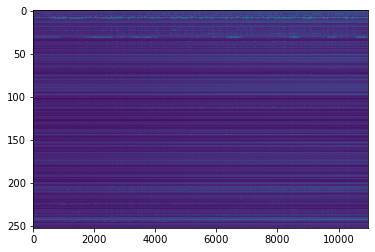

In [579]:
mouse = 52
plane = 3
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
session_name = '013'
roi_dir = plane_dir / f'{session_name}/plane0/roi'
F = np.load(roi_dir / 'F_reduced.npy', allow_pickle=True)
frame_time_df = pd.read_pickle(roi_dir / 'refined_frame_time.pkl')
use_ind = np.where(frame_time_df.remove_trial == False)[0]
fig, ax = plt.subplots()
ax.imshow(F[:,use_ind], aspect='auto')


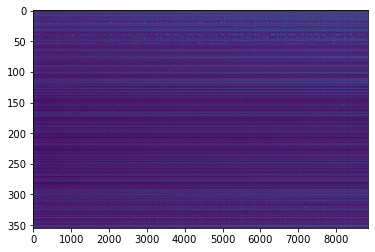

In [569]:
session_name = '012'
roi_dir = plane_dir / f'{session_name}/plane0/roi'
F = np.load(roi_dir / 'F_reduced.npy', allow_pickle=True)
fig, ax = plt.subplots()
ax.imshow(F, aspect='auto')

## Further refining frame_time_df does not rescue sudden drop of # of ROIs 
- Move on with 95th percentile threshold

In [597]:
# choose 0.05 (5th percentile) as the threshold
# apply to JK052
th_i = 1
skew_thresholds = [np.mean(sta[:,th_i]) for sta in skew_thresh_all]
print(skew_thresholds)

[0.20523036332027872, 0.24258705008537812, 0.2939186925233235, 0.3235047603682317, 0.30700556266531637, 0.30557644336858825, 0.3434729895018086, 0.4753097030810016]


In [607]:
# visualize the ones with above and below the threshold
# Check its own images and ROIs
mouse = 52
pi = 6
plane = planes[pi]

base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']

viewer = napari.Viewer()
for i in range(len(session_nums)):
# for i in range(1):
    session = session_nums[i]
    roi_dir = plane_dir / f'{session:03}' / f'plane0' / 'roi'
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    meanImg = ops['meanImg']
    viewer.add_image(meanImg, name=f'session_{session}', visible=False)
    # roi_fn = roi_dir / f'final_roi_results_{mouse:03d}_plane_{plane}_{session:03d}_wo_dendrite_filtering.npy'
    # roi = np.load(roi_fn, allow_pickle=True).item()
    # final_mask = np.zeros(roi['final_mask'].shape)
    # final_mask[np.where(roi['final_mask'] > 0)] = 1
    # # add the mask as label
    # viewer.add_labels(np.sum(final_mask, axis=2).astype(int), name=f'session_{session}_roi', visible=False)

    stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
    roi_masks = np.zeros(meanImg.shape, 'int')
    for s in stats:
        if abs(s['skew']) < skew_thresholds[pi]:
            roi_masks[s['ypix'], s['xpix']] = 1
        else:
            roi_masks[s['ypix'], s['xpix']] = 2
    viewer.add_labels(roi_masks, name=f'session_{session}_roi_skew', visible=False)



c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


## Top bottom portion of planes 2,3,4 from S013
- No ROI detected - why?
- Look at cp_masks and xrange and yrange

In [608]:
mouse = 52
plane = 2
session_num = 13
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
session_dir = plane_dir / f'{session_num:03}' / 'plane0'
roi_dir = session_dir / 'roi'

ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()


In [625]:
cp_masks = np.load(session_dir / f'{mouse:03}_plane_{plane}_{session_num:03}_cp_masks.npy', allow_pickle=True).item()

In [630]:
viewer = napari.Viewer()
for i in range(len(cp_masks['mean_mask_list'])):
    viewer.add_image(cp_masks['mean_mask_list'][i], name=f'diameter_ind_{i}')

c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [631]:
final_roi_results_fn = roi_dir / f'final_roi_results_{mouse:03d}_plane_{plane}_{session_num:03d}_wo_dendrite_filtering.npy'
final_roi_results = np.load(final_roi_results_fn, allow_pickle=True).item()

In [633]:
final_roi_results['final_mask'].shape

(387, 687, 235)

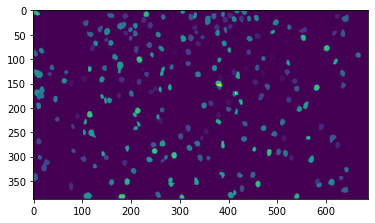

In [634]:
plt.imshow(np.sum(final_roi_results['final_mask'], axis=2))

In [635]:
from scripts import roi_remove_border as rrb
range_y, range_x = rrb.border_mask(ops)

In [658]:
plane = 8
session_num = 17
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
session_dir = plane_dir / f'{session_num:03}' / 'plane0'
roi_dir = session_dir / 'roi'

ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
rrb.border_mask(ops)

([5, -6], [6, -6])

## It was due to huge x-y movement (registration issue)

# Set iscell of JK052 based on the skewness filtering
- Before that, compare skewness distribution to the other mice

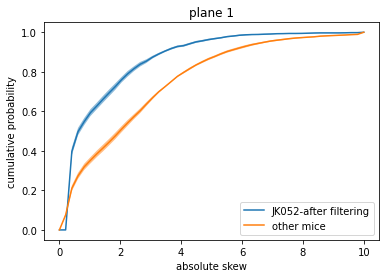

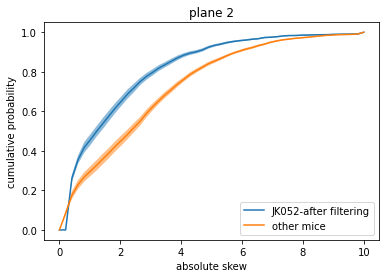

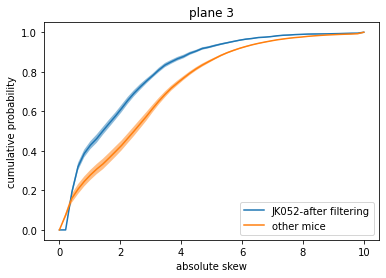

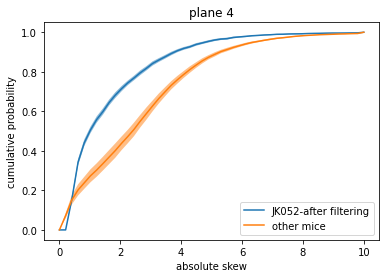

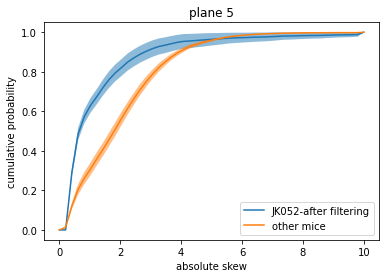

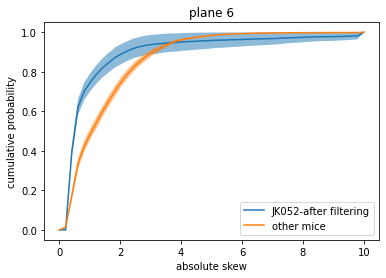

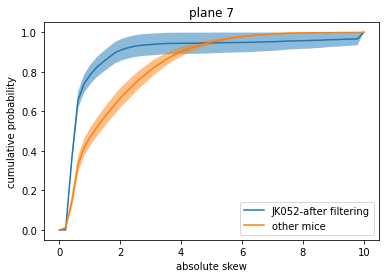

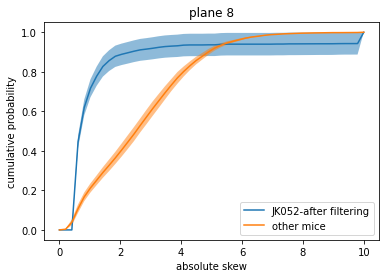

In [661]:
# do the same thing across planes
# to see if there is any plane bias
bins = [-10, *np.linspace(0, 10, 50)[:-1], 100]
xrange = np.linspace(0, 10, 50)

for plane in planes:
    cum_hist_mean_other_mice = []
    for mouse in mice:
        cum_hist_plane = []
        session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
        if mouse != 52:
            for session_name in session_names:
                plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
                roi_dir = plane_dir / f'{session_name}/plane0/roi'
                stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
                skews = [abs(s['skew']) for s in stats]

                hist_skew = np.histogram(skews, bins=bins)
                cum_hist = np.cumsum(hist_skew[0])/len(skews)
                cum_hist_plane.append(cum_hist)
            cum_hist_plane = np.asarray(cum_hist_plane)
            cum_hist_mean = np.mean(cum_hist_plane, axis=0)
            cum_hist_mean_other_mice.append(cum_hist_mean)
        else:
            skew_thresholds = np.mean(skew_thresh_all[plane-1][:,1])
            for session_name in session_names:
                plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
                roi_dir = plane_dir / f'{session_name}/plane0/roi'
                stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
                skews = [abs(s['skew']) for s in stats]
                skews = [skews[i] for i in np.where(np.asarray(skews) >= skew_thresholds)[0]]
                hist_skew = np.histogram(skews, bins=bins)
                cum_hist = np.cumsum(hist_skew[0])/len(skews)
                cum_hist_plane.append(cum_hist)
            cum_hist_plane_52 = np.asarray(cum_hist_plane)
            cum_hist_mean_52 = np.mean(cum_hist_plane_52, axis=0)
            cum_hist_sem_52 = np.std(cum_hist_plane_52, axis=0) / np.sqrt(len(session_names))
    cum_hist_mean_other_mice = np.asarray(cum_hist_mean_other_mice)
    cum_hist_mom_mean = np.mean(cum_hist_mean_other_mice, axis=0)
    cum_hist_mom_sem = np.std(cum_hist_mean_other_mice, axis=0) / np.sqrt(len(mice))

    fig, ax = plt.subplots()
    ax.plot(xrange, cum_hist_mean_52, label='JK052-after filtering')
    ax.fill_between(xrange, cum_hist_mean_52-cum_hist_sem_52, cum_hist_mean_52+cum_hist_sem_52, alpha=0.5)
    ax.plot(xrange, cum_hist_mom_mean, label='other mice')
    ax.fill_between(xrange, cum_hist_mom_mean-cum_hist_mom_sem, cum_hist_mom_mean+cum_hist_mom_sem, alpha=0.5)
    ax.legend()
    ax.set_title(f'plane {plane}')
    ax.set_xlabel('absolute skew')
    ax.set_ylabel('cumulative probability')


In [702]:
# calculating skew thresholds
bins = [*np.linspace(0, 10, 1000), 100]

cum_hist_allplanes = []
for plane in planes:
    cum_hist_mean = []
    for mouse in mice:
        if mouse != 52:
            cum_hist_plane = []
            session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
            for session_name in session_names:
                plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
                roi_dir = plane_dir / f'{session_name}/plane0/roi'
                stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
                skews = [abs(s['skew']) for s in stats]
                hist_skew = np.histogram(skews, bins=bins)
                cum_hist = np.cumsum(hist_skew[0])/len(skews)
                cum_hist_plane.append(cum_hist)
            cum_hist_plane = np.asarray(cum_hist_plane)
            cum_hist_mean.append(np.mean(cum_hist_plane, axis=0))
    cum_hist_mean = np.asarray(cum_hist_mean)
    cum_hist_allplanes.append(cum_hist_mean)

percentile_threshold = 0.05
skew_thresh_all = []
for pi in range(8):
    skew_thresh_plane = []
    for mi in range(5):
        x = [0, *cum_hist_allplanes[pi][mi]]
        y = [*np.linspace(0, 10, 1000), 100]
        interp_func = interp1d(x, y)
        skew_thresh_plane.append(interp_func(percentile_threshold))
    skew_thresh_all.append(np.asarray(skew_thresh_plane))
skew_thresholds = [np.mean(sta) for sta in skew_thresh_all]
skew_thresholds    

[0.20523036332027872,
 0.24258705008537812,
 0.2939186925233235,
 0.3235047603682317,
 0.30700556266531637,
 0.30557644336858825,
 0.3434729895018086,
 0.4753097030810016]

In [708]:
base_dir = Path(r'E:\TPM\JK\h5')
mouse = 52
planes = np.arange(1,9)
for pi in range(8):
    plane = planes[pi]
    plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
    skew_threshold = skew_thresholds[pi]
    session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
    for session_name in session_names:        
        session_dir = plane_dir / f'{session_name}' / 'plane0'
        roi_dir = session_dir / 'roi'
        iscell = np.load(roi_dir / 'iscell.npy', allow_pickle=True)
        stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
        for i in range(len(stats)):
            if abs(stats[i]['skew']) < skew_threshold:
                iscell[i,:] = 0
        np.save(roi_dir / 'iscell.npy', iscell)

    

# Dendrite filtering
- Some planes have too small ROIs
- This should be done before session-to-session registration.
- What is the best parameter?
    - Estimate by eyes.
    - I had 6 um diameter as the threshold before. It was too lax.
    - Test across 7,8,9, and 10 um.

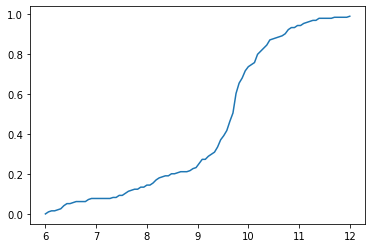

In [680]:
# First look at the distribution of equivalent diameter
def pix_to_eq_diameter(npix, pix_size):
    return np.sqrt(npix/np.pi) * 2 * pix_size

bins = [0, *np.linspace(6, 12, 100), 20]
mouse = 25
plane = 3
session = 4
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
roi_dir = plane_dir / f'{session:03}' / 'plane0' / 'roi'
stats = np.load(roi_dir / 'stat.npy', allow_pickle=True)
ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
pix_size = ops['umPerPix']

diameters = [pix_to_eq_diameter(s['npix'], pix_size) for s in stats]
hist_diam = np.histogram(diameters, bins=bins)[0]
cumhist_diam = np.cumsum(hist_diam) / len(diameters)
plt.plot(bins[1:-1], cumhist_diam[:-1])

In [675]:
final_mask = np.load(roi_dir / 'final_mask.npy', allow_pickle=True)
final_mask.shape

(387, 687, 315)

In [677]:
final_roi_results = np.load(roi_dir / f'final_roi_results_{mouse:03}_plane_{plane}_{session:03}_wo_dendrite_filtering.npy', allow_pickle=True).item()
final_roi_results['final_mask'].shape

(387, 687, 338)

In [683]:
mask_labels = np.zeros(ops['meanImg'].shape, 'int')
for s in stats:
    if pix_to_eq_diameter(s['npix'], pix_size) < 7:
        mask_labels[s['ypix'], s['xpix']] = 1
    else:
        mask_labels[s['ypix'], s['xpix']] = 2
viewer = napari.Viewer()
viewer.add_image(ops['meanImg'], name='meanImg')
viewer.add_labels(mask_labels, name='mask_labels')



c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


<Labels layer 'mask_labels' at 0x20e7ff90850>

In [697]:
mouse = 52
plane = 6
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']

viewer = napari.Viewer()
for i in range(len(session_nums)):
# for i in range(1):
    session = session_nums[i]
    roi_dir = plane_dir / f'{session:03}' / f'plane0' / 'roi'
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    meanImg = ops['meanImg']
    viewer.add_image(meanImg, name=f'session_{session}', visible=False)
    
    pix_size = ops['umPerPix']
    stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
    roi_masks = np.zeros(meanImg.shape, 'int')
    for s in stats:
        if pix_to_eq_diameter(s['npix'], pix_size) < 7:
            roi_masks[s['ypix'], s['xpix']] = 1
        elif pix_to_eq_diameter(s['npix'], pix_size) < 8:
            roi_masks[s['ypix'], s['xpix']] = 2
        else:
            roi_masks[s['ypix'], s['xpix']] = 3
    viewer.add_labels(roi_masks, name=f'session_{session}_roi_dendrite', visible=False)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [722]:
mouse = 52
plane = 1
session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
session_name = session_names[0]
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
session_dir = plane_dir / f'{session_name}' / 'plane0'
roi_dir = session_dir / 'roi'
ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
print(ops['umPerPix'])

0.8235294117647058


# 7 um equivalent diameter as the threshold

In [739]:
def pix_to_eq_diameter(npix, pix_size):
    return np.sqrt(npix/np.pi) * 2 * pix_size

base_dir = Path(r'E:\TPM\JK\h5')
diameter_threshold = 7
planes = np.arange(1,9)
for mouse in [52]:
    for plane in planes:
        plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
        session_names = use_mice_df.query('mouse==@mouse and plane==@plane').session.unique()
        for session_name in session_names:        
            session_dir = plane_dir / f'{session_name}' / 'plane0'
            roi_dir = session_dir / 'roi'
            ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
            if 'umPerPix' not in ops.keys():
                if mouse < 31:
                    ops['umPerPix'] = 0.7
                else:
                    ops['umPerPix'] = 0.8235294117647058
                np.save(roi_dir / 'ops.npy', ops)
                np.save(session_dir / 'ops.npy', ops)
            pix_size = ops['umPerPix']
            
            iscell = np.load(roi_dir / 'iscell.npy', allow_pickle=True)
            iscell[:,:] = 1

            stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
            for i in range(len(stats)):
                if pix_to_eq_diameter(stats[i]['npix'], pix_size) < diameter_threshold:
                    iscell[i,:] = 0
            np.save(roi_dir / 'iscell.npy', iscell)


# Final visual inspection
- dendrite filtered
- tdTomato from JK052

In [741]:
mouse = 52
plane = 2
base_dir = Path(r'E:\TPM\JK\h5')
plane_dir = base_dir / f'{mouse:03}' / f'plane_{plane}'
master_roi_fn = plane_dir / f'JK{mouse:03}_plane{plane}_cellpose_master_roi.npy'
master_roi = np.load(master_roi_fn, allow_pickle=True).item()

session_nums = master_roi['session_nums']

viewer = napari.Viewer()
for i in range(len(session_nums)):
    session = session_nums[i]
    roi_dir = plane_dir / f'{session:03}' / f'plane0' / 'roi'
    ops = np.load(roi_dir / 'ops.npy', allow_pickle=True).item()
    meanImg = ops['meanImg']
    viewer.add_image(meanImg, name=f'session_{session}', visible=False)
    
    pix_size = ops['umPerPix']
    stats = np.load(roi_dir / 'stat_refined.npy', allow_pickle=True)
    iscell = np.load(roi_dir / 'iscell.npy', allow_pickle=True)
    assert len(stats) == iscell.shape[0]
    roi_masks = np.zeros(meanImg.shape, 'int')
    for i in range(len(stats)):
        if iscell[i,0] == 0:
            roi_masks[stats[i]['ypix'], stats[i]['xpix']] = 1
        else:
            roi_masks[stats[i]['ypix'], stats[i]['xpix']] = 2
    viewer.add_labels(roi_masks, name=f'session_{session}_roi_dendrite', visible=False)


c:\Users\shires\Anaconda3\envs\suite2p\lib\site-packages\napari\_vispy\vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)
